In [ ]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np
from simsopt.field import MGrid
from r8hermt import r8herm_spline
import time

# Close all previous plots
plt.close('all')

# Define current values for coils
coil_currents = {
    'tf_1': 50, 'tf_2': 50, 'tf_3': 50, 'tf_4': 50,
    'tf_5': 50, 'tf_6': 50, 'pf': 5, 'hw': 5,
    'ovf': -80, 'ivf': -40
}
extcur = np.array(list(coil_currents.values()))

# File paths
input_path = "/home/zkg/h1_scan/input"
mgrid_filename = 'mgrid_h1_free.nc'
mgrid_path = f"{input_path}/{mgrid_filename}"
temp_path = "/home/zkg/h1_scan/temp"

# Load MGrid data
mgrid_data = MGrid.from_file(mgrid_path)
coil_list = mgrid_data.coil_names
num_coils = len(coil_list)
r_max, r_min, z_max, z_min = mgrid_data.rmax, mgrid_data.rmin, mgrid_data.zmax, mgrid_data.zmin
nr, nz, nphi, nfp = mgrid_data.nr, mgrid_data.nz, mgrid_data.nphi, mgrid_data.nfp + 1

# Calculate grid parameters
grid_unit = (r_max - r_min) / (nr - 1)
r_range = np.arange(r_min / grid_unit, r_max / grid_unit + 1, dtype=int)*grid_unit
z_range = np.arange(z_min / grid_unit, z_max/ grid_unit + 1, dtype=int)*grid_unit
phi_radrange = np.linspace(0, 360/nfp,nphi,endpoint=False)
phi_arcrange = np.deg2rad(phi_radrange)
delta_phi = np.deg2rad(360 / nfp / (nphi))
# phirad_grid,r_grid, z_grid = np.meshgrid(phi_radrange,r_range, z_range,indexing='ij')

bp_raw = mgrid_data.bp_arr.transpose((0,1,3,2))*1000 # phi,r,z.set current units = 1kA
br_raw = mgrid_data.br_arr.transpose((0,1,3,2))*1000
bz_raw = mgrid_data.bz_arr.transpose((0,1,3,2))*1000
bp_raw[bp_raw == 0] = 1e-10
br_raw[br_raw == 0] = 1e-10
bz_raw[bz_raw == 0] = 1e-10

# dR = (br_raw/bp_raw)*r_grid*delta_phi
# dZ = (bz_raw/bp_raw)*r_grid*delta_phi

dR_spline = np.zeros((num_coils, 8, nphi, nr, nz))
dZ_spline = np.zeros((num_coils, 8, nphi, nr, nz))
bp_spline = np.zeros((num_coils, 8, nphi, nr, nz))
br_spline = np.zeros((num_coils, 8, nphi, nr, nz))
bz_spline = np.zeros((num_coils, 8, nphi, nr, nz))

print(f"Begin spline interpolation")
time_start = time.time()
for i in range(num_coils):
    bp_spline[i,:,:,:,:] = r8herm_spline(phi_radrange, r_range, z_range, bp_raw[i,:,:,:])
    br_spline[i,:,:,:,:] = r8herm_spline(phi_radrange, r_range, z_range, br_raw[i,:,:,:])
    bz_spline[i,:,:,:,:] = r8herm_spline(phi_radrange, r_range, z_range, bz_raw[i,:,:,:])
time_end = time.time()

print(f"Spline interpolation done in {time_end - time_start:.3f} seconds")
# Save spline data
np.savez(f"{temp_path}/spline_data.npz", bp_spline=bp_spline, br_spline=br_spline, bz_spline=bz_spline,r_range=r_range,z_range=z_range,phi_radrange=phi_radrange)

In [ ]:
%reset -f

import numpy as np

temp_path = "/home/zkg/h1_scan/temp"
spline_data = np.load(f"{temp_path}/spline_data.npz")

bp_spline = spline_data['bp_spline']
bp_spline = np.asfortranarray(bp_spline)
br_spline = spline_data['br_spline']
br_spline = np.asfortranarray(br_spline)
bz_spline = spline_data['bz_spline']
bz_spline = np.asfortranarray(bz_spline)
r_range = spline_data['r_range']
r_range = np.asfortranarray(r_range)
z_range = spline_data['z_range']
z_range = np.asfortranarray(z_range)
phi_radrange = spline_data['phi_radrange']
phi_radrange = np.asfortranarray(phi_radrange)
phi_arcrange = np.deg2rad(phi_radrange)
nphi = len(phi_radrange)
nr = len(r_range)
nz = len(z_range)

delta_phiarc = np.deg2rad(phi_radrange[1] - phi_radrange[0])
delta_phirad = phi_radrange[1] - phi_radrange[0]
delta_phi = delta_phirad
print("Spline data loaded")

Spline data loaded


Begin fieldline tracing
 ?herm3ev:  xget= 2.0769E+00 out of range  0.0000E+00 to  2.0769E+00
 ?herm3ev:  xget= 2.0769E+00 out of range  0.0000E+00 to  2.0769E+00
 ?herm3ev:  xget= 2.0769E+00 out of range  0.0000E+00 to  2.0769E+00
 ?herm3ev:  xget= 2.0769E+00 out of range  0.0000E+00 to  2.0769E+00
 ?herm3ev:  xget= 2.0769E+00 out of range  0.0000E+00 to  2.0769E+00
 ?herm3ev:  xget= 2.0769E+00 out of range  0.0000E+00 to  2.0769E+00
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2076943904268D+01   r2 =                  NaN
Integration failed at step 239
Fieldline tracing done in 0.10500 s


/tmp/ipykernel_1342799/2614647566.py:38: RuntimeWarning: invalid value encountered in scalar divide
  return [br_tem / bp_tem, bz_tem / bp_tem]


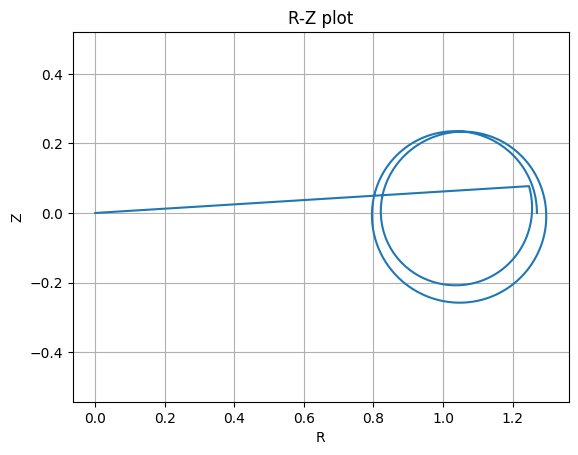

In [ ]:
from scipy.integrate import solve_ivp
from r8hermt import r8herm_interpolation
import numpy as np
import time

coil_currents = {
    'tf_1': 50, 'tf_2': 50, 'tf_3': 50, 'tf_4': 50,
    'tf_5': 50, 'tf_6': 50, 'pf': 5, 'hw': 5,
    'ovf': -80, 'ivf': -40
}

extcur = np.array(list(coil_currents.values()))

bp_spline_extcur = bp_spline * extcur[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis] 
bp_spline_extcur = np.sum(bp_spline_extcur, axis=0)
br_spline_extcur = br_spline * extcur[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
br_spline_extcur = np.sum(br_spline_extcur, axis=0)
bz_spline_extcur = bz_spline * extcur[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
bz_spline_extcur = np.sum(bz_spline_extcur, axis=0)



def trace_single_fieldlines(R_start, Z_start, phi_start, phi_arcrange, r_range, z_range, nsteps, bp_spline_extcur, br_spline_extcur, bz_spline_extcur):
    R = np.zeros(nsteps)
    Z = np.zeros(nsteps)
    phi = np.zeros(nsteps)
    R[0] = R_start
    Z[0] = Z_start
    phi[0] = phi_start
    nphi = len(phi_radrange)
    nr = len(r_range)
    nz = len(z_range)
    delta_phi = phi_arcrange[1] - phi_arcrange[0]
    
    # time_start = time.time()
    
    def fieldline(phi, rz):
        R, Z = rz
        bp_tem = r8herm_interpolation(phi, R, Z, phi_arcrange, r_range, z_range, bp_spline_extcur)
        br_tem = r8herm_interpolation(phi, R, Z, phi_arcrange, r_range, z_range, br_spline_extcur)
        bz_tem = r8herm_interpolation(phi, R, Z, phi_arcrange, r_range, z_range, bz_spline_extcur)
        return [br_tem / bp_tem, bz_tem / bp_tem]

    for i in range(nsteps - 1):
        R_temp = R[i]
        Z_temp = Z[i]
        phi_temp = i%
        sol = solve_ivp(fieldline, [phi_temp, phi_temp + delta_phi], [R_temp, Z_temp], method='LSODA', rtol=1e-12)
        if sol.success:
            R[i + 1] = sol.y[0][-1]
            Z[i + 1] = sol.y[1][-1]
            phi[i + 1] = phi[i] + delta_phi
        else:
            print(f"Integration failed at step {i + 1}")
            break

        if R[i + 1] < r_range[0] or R[i + 1] > r_range[-1] or Z[i + 1] < z_range[0] or Z[i + 1] > z_range[-1]:
            print(f"Fieldline out of range at step {i + 1}")
            break

        time_end = time.time()
        # print(f"R = {R[i + 1]:.3f}, Z = {Z[i + 1]:.3f}, phi = {phi[i + 1]:.3f}")
        # print(f"Step {i + 1} done in {time_end - time_start:.3f} s")

    line = np.vstack((R, Z, phi))
    return line

print("Begin fieldline tracing")
nsteps = 240
R_start = 1.27
Z_start = 0
phi_start = 0
time_start = time.time()
test_line = trace_single_fieldlines(R_start, Z_start, phi_start, phi_arcrange, r_range, z_range, nsteps, bp_spline_extcur, br_spline_extcur, bz_spline_extcur)
time_end = time.time()
print(f"Fieldline tracing done in {time_end - time_start:.5f} s")

import matplotlib.pyplot as plt
#plot R-phi 2D plot
plt.figure()
plt.plot(test_line[0], test_line[1])
plt.xlabel('R')
plt.ylabel('Z')
plt.title('R-Z plot')
plt.axis('equal')
plt.grid()
plt.show()

from scipy.io import savemat
savemat('test_line.mat', {'test_line': test_line})


In [ ]:
import matplotlib.pyplot as plt
